# Training YOLOv8
### Example directly applied from https://keras.io/examples/vision/yolov8/
### Modified from XMP to TXT label files

In [ ]:
import os
from tqdm.auto import tqdm
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization
import numpy as np

In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [3]:
import keras
import keras_cv

In [4]:
# 20% for validation
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0

In [5]:
# One class detection
class_ids = [
    "apple",
]

class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [6]:
class_ids

['apple']

In [7]:
class_mapping

{0: 'apple'}

In [8]:
# Path to images and annotations
path_images = "./data/train/images"
path_annot = "./data/train/labels"

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


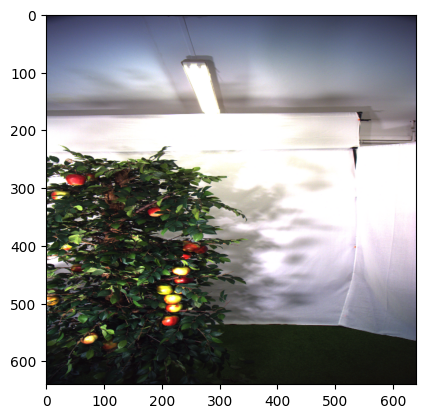

In [10]:
img = mpimg.imread('./data/train/images/data-1.png')
imgplot = plt.imshow(img)

In [11]:
img[0,0]

array([0.08627451, 0.08235294, 0.13333334, 1.        ], dtype=float32)

## Sorting image and annotation files lists
## After that these two lists will be in sync

In [12]:
# Get all TXT file paths in path_annot and sort them
txt_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".txt")
    ]
)


In [13]:
# Get all PNG image file paths in path_images and sort them
image_paths = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".png")
    ]
)

## Extracting bounding box and class data from TXT annotation files

In [14]:
def parse_annotation(txt_file):
    df = pd.read_csv(txt_file, sep=' ', names=['id', 'xmin', 'ymin', 'xmax', 'ymax'])
    boxes = [list(df[['xmin', 'ymin', 'xmax', 'ymax']].iloc[i]) for i in range(len(df))]
    # Auxilliary step, resizing boxes for the particular used image format
    boxes = [[640 * boxes[i][0],  640 * boxes[i][1],  640 * boxes[i][2], 640 * boxes[i][3]]  for i in range(len(df))]
    classes = list(df['id'])
    
    return boxes, classes

## Sample file and parsing result

In [15]:
txt_files[0]

'./data/train/labels/data-1.txt'

In [16]:
parse_annotation(txt_files[0])

([[31.98360261437901, 276.4532211092409, 71.51937254901952, 297.9314059831904],
  [7.760983006535937, 304.9476130420134, 44.2341228758169, 323.27566413445055],
  [174.32629542483585,
   332.5057764033574,
   210.2425934640512,
   351.5690422857101],
  [234.7115084967315,
   395.5249737142816,
   269.24641045751554,
   412.6937535462144],
  [256.81384575163327,
   399.07713505881924,
   281.44874248365954,
   415.6538879999955],
  [216.81761045751617,
   434.8438201008365,
   253.42460653594753,
   453.0782483361305],
  [189.18968888888895,
   467.405299092432,
   221.88272941176447,
   486.7053757310874],
  [202.54318431372542,
   483.8636466554573,
   237.76878431372546,
   503.63734480671746],
  [205.0757437908493, 499.2453313613389, 239.1501803921562, 517.7275848067168],
  [198.39899607843137, 520.806124638649, 231.7827346405229, 540.6982281680608],
  [58.96499869281043, 550.6608016134394, 92.54684444444416, 571.7094227899098],
  [93.59627712418303,
   563.7487263193223,
   126.9157

In [17]:
bbox = []
classes = []
for txt_file in tqdm(txt_files):
    boxes, class_ids = parse_annotation(txt_file)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/537 [00:00<?, ?it/s]

### Representing image data as ragged tensors for efficiency 
### (there are differing numbers of cases on each photo)

In [ ]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

## Creating dataset - at this stage images as paths only

In [19]:
data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [20]:
# Determine the number of validation samples
num_val = int(len(txt_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

## Data processing routines for dataset data retrieval

In [21]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

## Data augmentation and transformation

In [22]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

In [23]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

### For validation dataset only resizing, no augmentation

In [24]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

## Tranforming dataset to training-ready form with features and labels

In [25]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Small backbone network from COCO dataset

In [ ]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

## Defining the model
### fpn_depth specifies Feature Pyramid Network depth

In [27]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

In [28]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

## Callback for preservig better models (lib broken at this point)

In [29]:
#class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
#    def __init__(self, data, save_path):
#        super().__init__()
#        self.data = data
#        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
#            bounding_box_format="xyxy",
#            evaluate_freq=1e9,
#        )

#        self.save_path = save_path
#        self.best_map = -1.0

#    def on_epoch_end(self, epoch, logs):
#        self.metrics.reset_state()
#        for batch in self.data:
#            images, y_true = batch[0], batch[1]
#            y_pred = self.model.predict(images, verbose=0)
#            self.metrics.update_state(y_true, y_pred)

#        metrics = self.metrics.result(force=True)
#        logs.update(metrics)

#        current_map = metrics["MaP"]
#        if current_map > self.best_map:
#            self.best_map = current_map
#            self.model.save(self.save_path)  # Save the model when mAP improves

#        return logs


## TRAINING

In [31]:
history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=13,
    # COCOMetric callback is broken as of now 
    #callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5")],
)

Epoch 1/13


2024-01-12 16:03:53.115645: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-12 16:03:53.277233: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-12 16:03:54.248025: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-12 16:03:58.564914: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f6ed8f3a250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-12 16:03:58.564937: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-01-12 16:03:58.567957: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705075438.614905  139491 device_co

107/107 [==============================] - 30s 70ms/step - loss: 308.1635 - box_loss: 3.5239 - class_loss: 304.6395 - val_loss: 160.6741 - val_box_loss: 4.9413 - val_class_loss: 155.7328
Epoch 2/13
107/107 [==============================] - 7s 62ms/step - loss: 4.5662 - box_loss: 2.2570 - class_loss: 2.3092 - val_loss: 4.0163 - val_box_loss: 2.4094 - val_class_loss: 1.6070
Epoch 3/13
107/107 [==============================] - 7s 62ms/step - loss: 3.3590 - box_loss: 1.9477 - class_loss: 1.4112 - val_loss: 3.1392 - val_box_loss: 1.9453 - val_class_loss: 1.1939
Epoch 4/13
107/107 [==============================] - 7s 64ms/step - loss: 3.0637 - box_loss: 1.8234 - class_loss: 1.2403 - val_loss: 3.2427 - val_box_loss: 2.0590 - val_class_loss: 1.1836
Epoch 5/13
107/107 [==============================] - 7s 62ms/step - loss: 2.8606 - box_loss: 1.7255 - class_loss: 1.1351 - val_loss: 3.4215 - val_box_loss: 2.2454 - val_class_loss: 1.1761
Epoch 6/13
107/107 [==============================] - 7s 

## Training performance

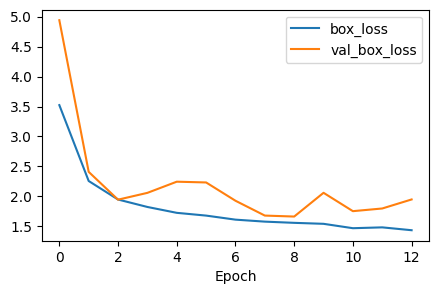

In [40]:
plt.figure(figsize=(5, 3))
plt.plot(history.history['box_loss'], label='box_loss')
plt.plot(history.history['val_box_loss'], label='val_box_loss')
#plt.plot(history.history['val_class_loss'], label='val_class_loss')
plt.xlabel('Epoch')
plt.legend()

## Saving the Model

In [41]:
model_dir = "./model"
model_version = 1
model_export_path = f'{model_dir}/{model_version}'

In [ ]:
tf.saved_model.save(
    yolo,
    export_dir=model_export_path)

In [ ]:
#print(f'SavedModel files: {os.listdir(model_export_path)}')

## Prediction visualisation

1/1 [==============================] - 2s 2s/step


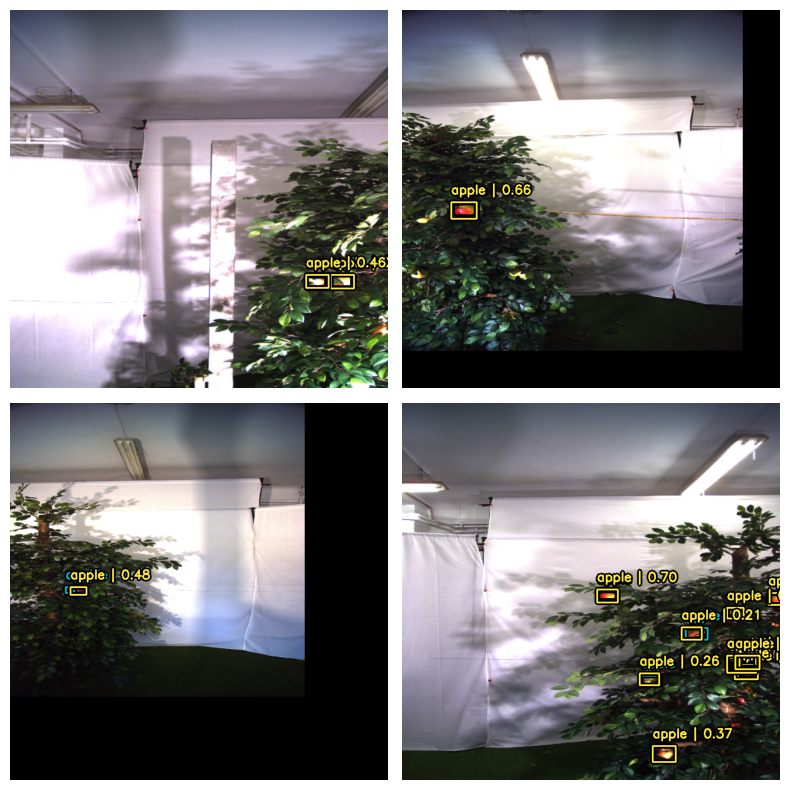

In [43]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")

## A single file inference

In [44]:
img_path = './data/valid/images/data-750.png'

In [45]:
img = load_image(img_path)[tf.newaxis, :]

In [46]:
y_pred = yolo.predict(img)

1/1 [==============================] - 1s 1s/step


In [47]:
y_pred

{'boxes': array([[[ 90.58298  , 302.68958  , 125.65418  , 322.5737   ],
         [194.65598  , 407.5495   , 232.01216  , 429.3081   ],
         [  0.6982155, 268.99026  ,  45.590622 , 294.7103   ],
         [183.14198  , 321.33255  , 220.02783  , 341.1949   ],
         [280.61267  , 402.03525  , 305.97607  , 416.47623  ],
         [ 64.76513  , 533.8929   ,  99.98958  , 554.9392   ],
         [193.17526  , 405.97812  , 234.51921  , 435.12274  ],
         [ -6.0006657, 340.61322  ,  12.5896225, 357.72687  ],
         [ 57.97178  , 395.18277  ,  86.810936 , 412.57993  ],
         [  8.607586 , 270.29352  ,  47.3999   , 291.44482  ],
         [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
         [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
         [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
         [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
         [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
         [ -1.       ,  -1.       ,  -1.      

In [48]:
y_pred['boxes'].shape

(1, 100, 4)

In [49]:
y_pred = bounding_box.to_ragged(y_pred)

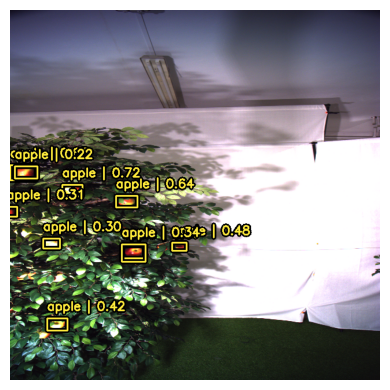

In [50]:
visualization.plot_bounding_box_gallery(
        load_image(img_path)[tf.newaxis, :],
        value_range=(0, 255),
        bounding_box_format="xyxy",
        #y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=1,
        cols=1,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

## Misc code used to test model saved signatures

In [ ]:
y_pred

In [ ]:
yolo(img)

In [ ]:
raw_pred = yolo(img)

In [ ]:
raw_pred

In [ ]:
from keras_cv import layers

In [ ]:
def decode_regression_to_boxes(preds):
    """Decodes the results of the YOLOV8Detector forward-pass into boxes.

    Returns left / top / right / bottom predictions with respect to anchor
    points.

    Each coordinate is encoded with 16 predicted values. Those predictions are
    softmaxed and multiplied by [0..15] to make predictions. The resulting
    predictions are relative to the stride of an anchor box (and correspondingly
    relative to the scale of the feature map from which the predictions came).
    """
    BOX_REGRESSION_CHANNELS = 64
    preds_bbox = keras.layers.Reshape((-1, 4, BOX_REGRESSION_CHANNELS // 4))(
        preds
    )
    preds_bbox = tf.nn.softmax(preds_bbox, axis=-1) * tf.range(
        BOX_REGRESSION_CHANNELS // 4, dtype="float32"
    )
    return tf.math.reduce_sum(preds_bbox, axis=-1)

In [ ]:
decode_regression_to_boxes(raw_pred['boxes'])

In [ ]:
 prediction_decoder = layers.NonMaxSuppression(
                bounding_box_format='xyxy',
                from_logits=False,
                confidence_threshold=0.2,
                iou_threshold=0.7,
            )

In [ ]:
def get_anchors(
    image_shape,
    strides=[8, 16, 32],
    base_anchors=[0.5, 0.5],
):
    """Gets anchor points for YOLOV8.

    YOLOV8 uses anchor points representing the center of proposed boxes, and
    matches ground truth boxes to anchors based on center points.

    Args:
        image_shape: tuple or list of two integers representing the height and
            width of input images, respectively.
        strides: tuple of list of integers, the size of the strides across the
            image size that should be used to create anchors.
        base_anchors: tuple or list of two integers representing the offset from
            (0,0) to start creating the center of anchor boxes, relative to the
            stride. For example, using the default (0.5, 0.5) creates the first
            anchor box for each stride such that its center is half of a stride
            from the edge of the image.

    Returns:
        A tuple of anchor centerpoints and anchor strides. Multiplying the
        two together will yield the centerpoints in absolute x,y format.

    """
    base_anchors = tf.convert_to_tensor(np.array(base_anchors, dtype="float32"), dtype=tf.float32)

    all_anchors = []
    all_strides = []
    for stride in strides:
        hh_centers = tf.range(0, image_shape[0], stride)
        ww_centers = tf.range(0, image_shape[1], stride)
        ww_grid, hh_grid = tf.meshgrid(ww_centers, hh_centers)
        grid = tf.cast(
            tf.reshape(tf.stack([hh_grid, ww_grid], 2), [-1, 1, 2]),
            "float32",
        )
        anchors = (
            tf.expand_dims(
                base_anchors * tf.convert_to_tensor(np.array([stride, stride], "float32"), dtype=tf.float32), 0
            )
            + grid
        )
        anchors = tf.reshape(anchors, [-1, 2])
        all_anchors.append(anchors)
        all_strides.append(tf.repeat(stride, anchors.shape[0]))

    all_anchors = tf.cast(tf.concat(all_anchors, axis=0), "float32")
    all_strides = tf.cast(tf.concat(all_strides, axis=0), "float32")

    all_anchors = all_anchors / all_strides[:, None]

    # Swap the x and y coordinates of the anchors.
    all_anchors = tf.concat(
        [all_anchors[:, 1, None], all_anchors[:, 0, None]], axis=-1
    )
    return all_anchors, all_strides

In [ ]:
def dist2bbox(distance, anchor_points):
    """Decodes distance predictions into xyxy boxes.

    Input left / top / right / bottom predictions are transformed into xyxy box
    predictions based on anchor points.

    The resulting xyxy predictions must be scaled by the stride of their
    corresponding anchor points to yield an absolute xyxy box.
    """
    left_top, right_bottom = tf.split(distance, 2, axis=-1)
    x1y1 = anchor_points - left_top
    x2y2 = anchor_points + right_bottom
    return tf.concat((x1y1, x2y2), axis=-1)  # xyxy bbox


In [ ]:
  def decode_predictions(
        pred,
        images,
    ):
        boxes = pred["boxes"]
        scores = pred["classes"]

        boxes = decode_regression_to_boxes(boxes)

        anchor_points, stride_tensor = get_anchors(image_shape=images.shape[1:])
        stride_tensor = tf.expand_dims(stride_tensor, axis=-1)

        box_preds = dist2bbox(boxes, anchor_points) * stride_tensor
        box_preds = bounding_box.convert_format(
            box_preds,
            source="xyxy",
            target="xyxy",
            images=images,
        )

        return prediction_decoder(box_preds, scores)

In [ ]:
yolo.predict(img)

In [ ]:
raw_pred

In [ ]:
decode_predictions(raw_pred, img)

In [ ]:
## For reference: saving with a custom model signature

In [ ]:
#def export_model(model):
#    @tf.function(input_signature=[tf.TensorSpec([None, None, None, 3], tf.float32)])
#    def serving_fn(image):
#        predictions = model(image)
#        predictions = decode_predictions(raw_pred, image)
#        #return {"predictions": predictions}
#        return predictions
        
#    return serving_fn

In [ ]:
#tf.saved_model.save(
#    yolo,
#    export_dir=model_export_path)
#    #signatures={"serving_default": export_model(yolo)})